# A2 Bias in Data

Notebook to identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases. The 'Toxicity' and 'Personal Attacks' labelled datasets from Wikipedia are used for exploration.

Import the required libraries

In [1]:
import os
import numpy as np
import urllib
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Download the Data from Figshare

In [ ]:
files = dict()
files['attack_annotated_comments'] = 'https://ndownloader.figshare.com/files/7554634' 
files['attack_annotations'] = 'https://ndownloader.figshare.com/files/7554637' 
files['attack_worker_demographics'] = 'https://ndownloader.figshare.com/files/7640752'

files['toxicity_annotated_comments'] = 'https://ndownloader.figshare.com/files/7394542' 
files['toxicity_annotations'] = 'https://ndownloader.figshare.com/files/7394539' 
files['toxicity_worker_demographics'] = 'https://ndownloader.figshare.com/files/7640581'

def download_file(url, fname):
    """File to download the required data from url 
       and store it in fname
    """
    urllib.request.urlretrieve(url, fname)

Download all the required files and store them in the data folder (takes 2-5 min)

In [ ]:
for key, value in files.items():
    download_file(value, 'data/'+ key + '.tsv')

## Analysis 1: How well does the labeller demograchic distribution match the true population?
### Data Processing

In [2]:
## read in the files for personal attack dataset
att_comments = pd.read_csv('data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
att_annotations = pd.read_csv('data/attack_annotations.tsv',  sep = '\t')
att_demographic = pd.read_csv('data/attack_worker_demographics.tsv',  sep = '\t')


Remove newline and tab tokens


In [3]:
att_comments['comment'] = att_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
att_comments['comment'] = att_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [4]:
total_sample = len(att_demographic) #total number of labellers (unique)

#create age demographic distribution of the sample
age_demo = att_demographic.groupby('age_group',as_index=False).count()
age_demo['worker_id'] = age_demo['worker_id']*100/total_sample

#create gender demographic distribution of the sample
gend_demo = att_demographic.groupby('gender',as_index=False).count()
gend_demo['worker_id'] = gend_demo['worker_id']*100/total_sample

Read in data about the population distribution for 2016 [1]

**Note: Year 2016 was chosen because the labelling was performed in 2016-2017

In [5]:
#read in population data for 2016
age_gender = pd.read_csv('data/2016_population_data.csv')
population = pd.read_csv('data/2016_total_population.csv')

population['Population'] = population['Population'].str.replace(",", "")
total_pop = population['Population'].astype(int).sum()

#convert % strings to floats
age_gender['Male % of Population']=age_gender['Male % of Population'].str.replace("%", "").astype(float)
age_gender['Female % of Population']=age_gender['Female % of Population'].str.replace("%", "").astype(float)
age_gender['Male'] = age_gender['Male % of Population']*total_pop/100 #percentage of total population
age_gender['Female'] = age_gender['Female % of Population']*total_pop/100

age_gender['Total'] = age_gender['Male'] + age_gender['Female'] #calculate total population by age

    Create function to bin ages in population dataset similar to sample attack dataset above

In [6]:
def age_binning(x):
    """Function to take in an age value and
       bin it into one of the following 5 catgories
    """
    if x < 18:
        return 'Under 18'
    elif x < 30:
        return '18-30'
    elif x < 45:
        return '30-45'
    elif x<60:
        return '45-60'
    else:
        return 'Over 60'
    
##bin the ages to be consistent with age group
age_gender['Age'] = age_gender['Age'].str.replace("+", "").astype(int) #convert age to int
age_gender['age_bin'] = age_gender['Age'].apply(lambda x: age_binning(x))

### Age distribution 

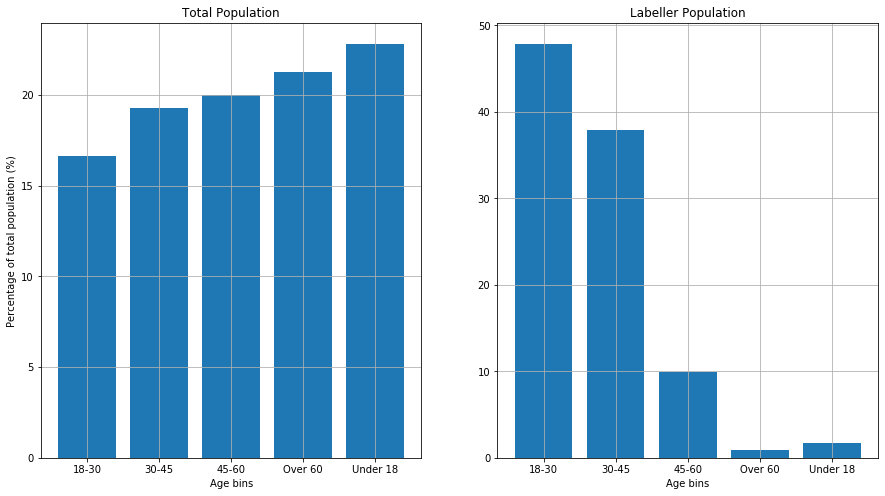

In [7]:
age_dist = age_gender.groupby('age_bin', as_index=False).sum()
age_dist['Total Percentage']= age_dist['Total']*100/total_pop #percentage of total population
#Plot the age distribution of the population vs the labeller sample

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

ax1.bar(age_dist['age_bin'],age_dist['Total Percentage'])
ax1.set_ylabel('Percentage of total population (%)')
ax1.set_xlabel('Age bins')
ax1.set_title('Total Population')
ax1.grid()

ax2.bar(age_demo['age_group'],age_demo['worker_id']) #sample distribution
ax2.set_xlabel('Age bins')
ax2.set_title('Labeller Population')
ax2.grid()

<b> The personal attack dataset labeller demographic shows skew in the age distribution of the labellers compared to the population. About 85% the labellers are in the 18-45 range but the true population has a larger proportion of much older and younger people. </b> What a certain age group might find as an attack or offensive may not be the same. In fact the vocabulary and lingo used by a teenager is vastly different from that used by someone over 45.

### Gender Distribution

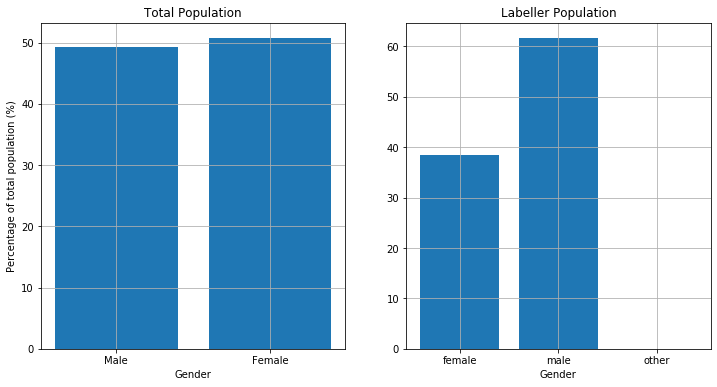

In [8]:
gend_dist = [age_gender['Male'].sum()*100/total_pop,age_gender['Female'].sum()*100/total_pop] #percentage of total population

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.bar(['Male','Female'],gend_dist)
ax1.set_ylabel('Percentage of total population (%)')
ax1.set_xlabel('Gender')
ax1.set_title('Total Population')
ax1.grid()

ax2.bar(gend_demo['gender'],gend_demo['worker_id']) #sample distribution
ax2.set_xlabel('Gender')
ax2.set_title('Labeller Population')
ax2.grid()

<b> The personal attack dataset labeller demographic shows skew in the gender distribution of the labellers compared to the population. About 62% the labellers are male but the true population has a more equal share of male and female. </b> There is no information about if the labeller population comprised of members of the LGBTQ community (the other category only consists of 1 person). However there is a much larger proportion of LGBTQ people in the true population estimated by https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5508189/

### Implications of demographic skew

A very similar skew is also present in the toxicity dataset

# Analysis 2: Are certain labels more likely to be grouped as toxic?

In [9]:
## read in the files for personal attack dataset
tox_comments = pd.read_csv('data/toxicity_annotated_comments.tsv', sep = '\t', index_col = 0)
tox_annotations = pd.read_csv('data/toxicity_annotations.tsv',  sep = '\t')
tox_demographic = pd.read_csv('data/toxicity_worker_demographics.tsv',  sep = '\t')

tox_comments['comment'] = tox_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
tox_comments['comment'] = tox_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

toxic_df = tox_annotations.merge(tox_comments, on = 'rev_id')

Inspired by the analysis on certain communites or names [2]

In [10]:
def class_balance(frame, keyword):
    """Returns the fraction of the dataset labeled toxic."""
    if keyword:
        frame = frame[frame['comment'].str.contains(keyword, case=False)]
    return len(frame.query('toxic')) / len(frame)

In [11]:
toxic_comments = tox_comments.copy() 
toxic_comments['toxic'] = tox_annotations.groupby('rev_id')['toxicity'].mean() > 0.5

print('overall fraction of comments labeled toxic:', class_balance(toxic_comments,keyword=None))

overall fraction of comments labeled toxic: 0.09620129504151897


In [ ]:
TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'Mexican',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'muslim', 'jew', 
              'christian','feminist', 'black', 'white']

print('overall class balance        {:.1f}%\t{} examples'.format(
    100 * class_balance(toxic_comments, keyword=None), len(toxic_comments)))

for fraction, num, term in sorted((class_balance(toxic_comments, term),
                                   len(toxic_comments[toxic_comments['comment'].str.contains(term, case=False)]),
                                   term)
                                  for term in TEST_TERMS):
    print('class balance for {:10s} {:.1f}%\t{} examples'.format(term, 100 * fraction, num))

<b> It can be seen that some terms that people identify with are more imbalanced in their toxicity distribution. This can potentially cause a model based on this data to learn terms like 'gay, queer' to be factors contributing to toxicity and thereby marginalizing the community more as can be seen in https://www.engadget.com/2017-09-01-google-perspective-comment-ranking-system.html</b>. Let us train a model on this data and see if this is true..

In [ ]:
toxic_comments['comment'] = toxic_comments['comment'].str.lower()
#split into classes specified in data file
train_tox_comments = toxic_comments.query("split=='train'") 
test_tox_comments = toxic_comments.query("split=='test'")

#classification pipeline 
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_tox_comments['comment'], train_tox_comments['toxic'])
auc = roc_auc_score(test_tox_comments['toxic'], clf.predict_proba(test_tox_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

<b> We can use our model to predict what some examples return as the predicted label. (toxicity threshold is 0.5)</b> 

In [ ]:
sent = "I am proud to be gay."
print(f'"{sent}" is labelled {clf.predict([sent])[0]} for toxicity with a probability of {clf.predict_proba([sent])[0][1]}')

In [ ]:
sent = 'You should attend the gay pride marathon.'
print(f'"{sent}" is labelled {clf.predict([sent])[0]} for toxicity with a probability of {clf.predict_proba([sent])[0][1]}')

In [ ]:
sent = "I am proud to be a woman."
print(f'"{sent}" is labelled {clf.predict([sent])[0]} for toxicity with a probability of {clf.predict_proba([sent])[0][1]}')

<b> Benign statements like above are learnt as toxic and could potentially be silenced/censored and take the voice away from minority communities.

## Analysis 3: Demographics and labelling behavior

In [12]:
tox_df = tox_annotations.merge(tox_demographic, on = 'worker_id')
tox_df = tox_df.merge(tox_comments, on = 'rev_id')
tox_df = tox_df[tox_df.gender!='other']
tox_df.head()

,rev_id,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education,comment,year,logged_in,ns,sample,split
0,2232.0,723,0,0.0,female,0,30-45,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train
1,2232.0,4000,0,0.0,male,1,18-30,hs,This: :One can make an analogy in mathematical...,2002,True,article,random,train
2,2232.0,3989,0,1.0,female,0,18-30,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train
3,2232.0,1574,0,1.0,female,0,30-45,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train
4,2232.0,1508,0,1.0,female,1,45-60,hs,This: :One can make an analogy in mathematical...,2002,True,article,random,train


### Is there a statistical significance in mean toxicity between female and male identified labellers?

In [13]:
tox_df[['gender','toxicity']].groupby('gender').agg(["mean", "std"]).reset_index()

gender  toxicity          
               mean       std
0  female  0.157093  0.363889
1    male  0.139886  0.346869

In [14]:
a = tox_df[tox_df.gender=='male']['toxicity']
b = tox_df[tox_df.gender=='female']['toxicity']
stat, p = scipy.stats.ttest_ind(a, b)
print(stat)
print(p)

-26.80805998939183
2.8652180710249847e-158


# Analysis 4: Is there a time trend in toxic comments

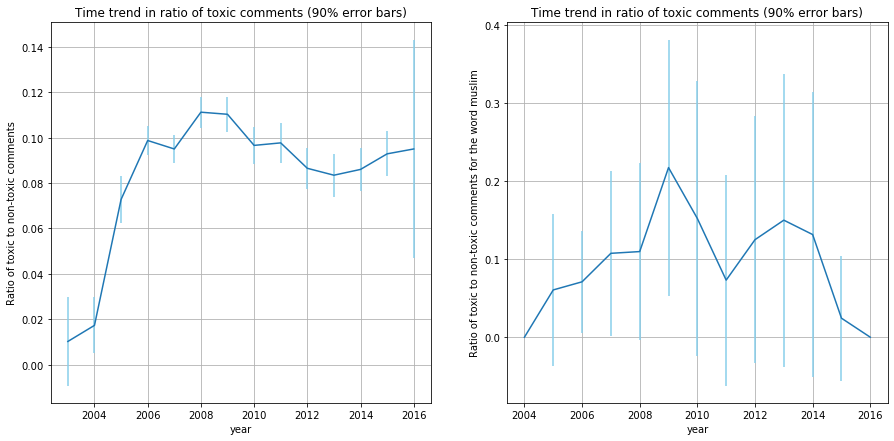

In [15]:
time_df = toxic_comments[['year','toxic']].groupby('year',as_index=False).agg(["mean", "sem"]).reset_index()
time_df = time_df[time_df.year > 2002]

#trend in toxicity for comments containing the word muslim 
comm_comments = toxic_comments[toxic_comments['comment'].str.contains('muslim', case=False)]
time_df1 = comm_comments[['year','toxic']].groupby('year',as_index=False).agg(["mean", "sem"]).reset_index()
time_df1 = time_df1[time_df1.year > 2002]

#plot the time series
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

ax1.errorbar(time_df['year'],time_df['toxic']['mean'],yerr = time_df['toxic']['sem']*2*1.64, ecolor='skyblue')
ax1.set_ylabel('Ratio of toxic to non-toxic comments')
ax1.set_xlabel('year')
ax1.set_title('Time trend in ratio of toxic comments (90% error bars)')
ax1.grid()

ax2.errorbar(time_df1['year'],time_df1['toxic']['mean'],yerr = time_df1['toxic']['sem']*2*1.64, ecolor='skyblue') 
ax2.set_xlabel('year')
ax2.set_ylabel('Ratio of toxic to non-toxic comments for the word muslim')
ax2.set_title('Time trend in ratio of toxic comments (90% error bars)')
ax2.grid()

### Try it yourself, enter a word and view the trend

In [ ]:
word = input('Enter a word to check toxicity for:')

comm_comments = toxic_comments[toxic_comments['comment'].str.contains(word, case=False)]
time_df1 = comm_comments[['year','toxic']].groupby('year',as_index=False).agg(["mean", "sem"]).reset_index()
time_df1 = time_df1[time_df1.year > 2003]

plt.errorbar(time_df1['year'],time_df1['toxic']['mean'],yerr = time_df1['toxic']['sem']*2*1.64, ecolor='skyblue') 
plt.xlabel('year')
plt.ylabel(f'Ratio of toxic to non-toxic comments for the word {word}')
plt.title('Time trend in ratio of toxic comments (90% error bars)')
plt.grid()

### Word cloud visualizations of the most common toxic words in the two datasets

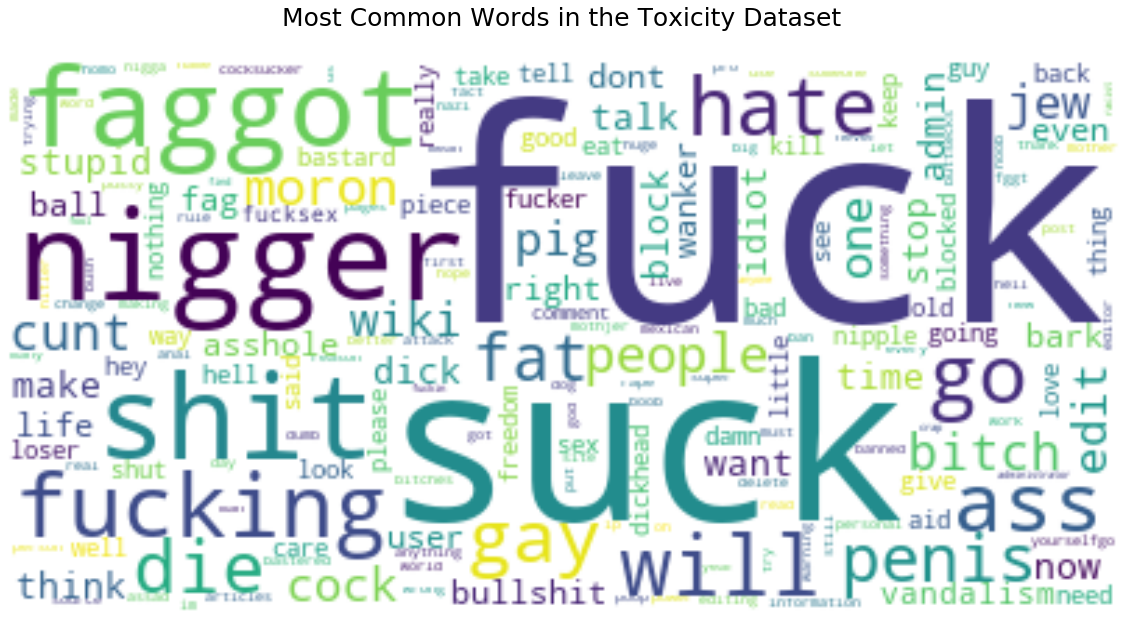

In [18]:
df = toxic_comments[toxic_comments.toxic==True].copy() 
df['comment']= df['comment'].str.lower()
all_df = df['comment'].str.split(' ')

all_df_cleaned = []

for text in all_df:
    text = [x.strip(string.punctuation) for x in text]
    all_df_cleaned.append(text)

text_df = [" ".join(text) for text in all_df_cleaned]
final_text_df = " ".join(text_df)

stopwords = set(STOPWORDS)
stopwords.update(["know","article","say","come","page","wikipedia",'hi'])

wordcloud_df = WordCloud(stopwords=stopwords,background_color="white",collocations = False).generate(final_text_df)

plt.figure(figsize = (20,20))
plt.imshow(wordcloud_df, interpolation='bilinear')
plt.title('Most Common Words in the Toxicity Dataset \n',fontdict = {'fontsize' : 25})
plt.axis("off")
plt.savefig('images/toxic_wc.png') #save to file
plt.show()


In [ ]:
att_comments['attack'] = att_annotations.groupby('rev_id')['attack'].mean() > 0.5

df = att_comments[att_comments.attack==True].copy() 
df['comment']= df['comment'].str.lower()
all_df = df['comment'].str.split(' ')

all_df_cleaned = []

for text in all_df:
    text = [x.strip(string.punctuation) for x in text]
    all_df_cleaned.append(text)

text_df = [" ".join(text) for text in all_df_cleaned]
final_text_df = " ".join(text_df)

stopwords = set(STOPWORDS)
stopwords.update(["know","article","say","come","page","wikipedia",'hi'])

wordcloud_df = WordCloud(stopwords=stopwords,background_color="white",collocations = False).generate(final_text_df)

plt.figure(figsize = (20,20))
plt.imshow(wordcloud_df, interpolation='bilinear')
plt.title('Most Common Words in the Personal Attacks Dataset \n',fontdict = {'fontsize' : 25})
plt.axis("off")
plt.show()

## References

[1] https://www.census.gov/popclock/ <br>
[2] https://github.com/conversationai/unintended-ml-bias-analysis/blob/master/unintended_ml_bias/Dataset_bias_analysis.ipynb